In [1]:
w_python = !which python
if 'home' in w_python[0]:
    pass
else:
    !pip install watermark

In [2]:
# !conda install -y opencv

In [3]:
%load_ext watermark
%watermark

Last updated: 2022-08-05T15:35:15.604017-05:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.10.102.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



In [4]:
import numpy as np

import math

import cv2  # opencv

import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.datasets import cifar10

2022-08-05 15:35:17.314395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


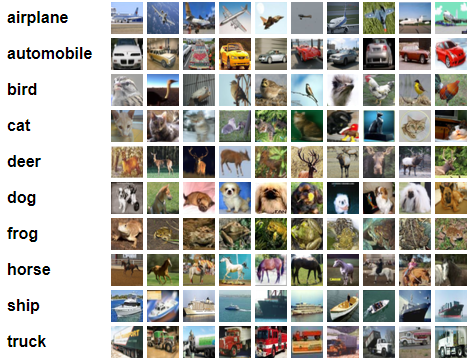

In [5]:
sns.set_style("whitegrid")

Se cargan los datos.

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

/home/ereyes/anaconda3/envs/env39/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


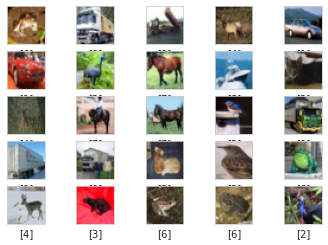

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots(5, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=y_train[i])

plt.show()

In [8]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

Se normalizan los datos.

In [9]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train = X_train / 255
X_test = X_test / 255

One-Hot Encoding

In [10]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

y_train.shape

(50000, 10)

In [11]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Convolutional Neural Network

In [12]:
X_train.shape

(50000, 32, 32, 3)

In [13]:
with tf.device("/GPU:0"):
    # En la última capa, la función de activación debe ser sigmoid en caso de problemas de clasificación binaria.
    # Para problemas de clasificación multiclase debe ser softmax

    # filters: número de filtros de salida en la convolución
    # kernel_size: altura y ancho de la ventana de convolución 2D, depende de la dimensión de la imágen
    # kernel_size: 3x3 imagenes pequeñas, 5x5 medianas, 7x7 grandes o videos

    height = X_train.shape[1]
    width = X_train.shape[2]
    channels = X_train.shape[3]

    target_count = y_train.shape[1]

    cnn_model = Sequential([Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(height, width, channels)),
                            Dropout(rate=0.2),
                            Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
                            MaxPooling2D(),

                            Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
                            Dropout(rate=0.2),
                            Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
                            MaxPooling2D(),

                            Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
                            Dropout(rate=0.2),
                            Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
                            MaxPooling2D(),

                            Flatten(),

                            Dense(units=1024, activation='relu', kernel_constraint=maxnorm(max_value=3)),

                            Dense(units=512, activation='relu', kernel_constraint=maxnorm(max_value=3)),
                            Dropout(rate=0.2),

                            Dense(units=target_count, activation='softmax')])

#   categorical_crossentropy: Retorna la clase predecida, en la última capa Dense units debe ser 1.
#   sparse_categorical_crossentropy: Retorna las probabilidades de cada clase, en la última capa Dense units debe ser el número de clases.

    cnn_model.compile(optimizer=Adam(learning_rate=0.001),      # optimizer
                      loss='categorical_crossentropy',          # función de pérdida
                      metrics=['accuracy'])                     # Métricas para observar la evolución del entrenamiento del modelo (precisión)

    display(cnn_model.summary())

    # Se debe ajustar el modelo dentro del ámbito, sino se ejecutará en dependencia si se activó o no la GPU
    historial_train = cnn_model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[])

2022-08-05 15:35:20.355272: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-05 15:35:20.370060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-05 15:35:21.685056: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-05 15:35:21.685121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 119.24GiB/s
2022-08-05 15:35:21.685202: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-05 15:35:21.740162: I tensorflow/stream_executor/platfor

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

None

2022-08-05 15:35:24.310133: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-05 15:35:24.314831: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2592005000 Hz


Epoch 1/20


2022-08-05 15:35:25.103820: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-05 15:35:25.550687: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-05 15:35:27.187740: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-05 15:35:27.259429: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


782/782 [==============================] - 48s 37ms/step - loss: 1.8705 - accuracy: 0.2965 - val_loss: 1.2759 - val_accuracy: 0.5304
Epoch 2/20
782/782 [==============================] - 13s 16ms/step - loss: 1.2280 - accuracy: 0.5549 - val_loss: 1.0319 - val_accuracy: 0.6364
Epoch 3/20
782/782 [==============================] - 13s 16ms/step - loss: 0.9586 - accuracy: 0.6585 - val_loss: 0.9077 - val_accuracy: 0.6868
Epoch 4/20
782/782 [==============================] - 13s 16ms/step - loss: 0.8049 - accuracy: 0.7169 - val_loss: 0.7996 - val_accuracy: 0.7201
Epoch 5/20
782/782 [==============================] - 13s 16ms/step - loss: 0.6868 - accuracy: 0.7575 - val_loss: 0.7744 - val_accuracy: 0.7350
Epoch 6/20
782/782 [==============================] - 13s 16ms/step - loss: 0.6129 - accuracy: 0.7855 - val_loss: 0.7438 - val_accuracy: 0.7485
Epoch 7/20
782/782 [==============================] - 13s 16ms/step - loss: 0.5191 - accuracy: 0.8141 - val_loss: 0.7379 - val_accuracy: 0.7528
Epo

Activaciones intermedias.

Las columnas representan las capas y las filas los filtros aplicados a cada capa.

/tmp/ipykernel_130/4194587996.py:30: RuntimeWarning: invalid value encountered in true_divide
  activation_res /= activation_res.std()


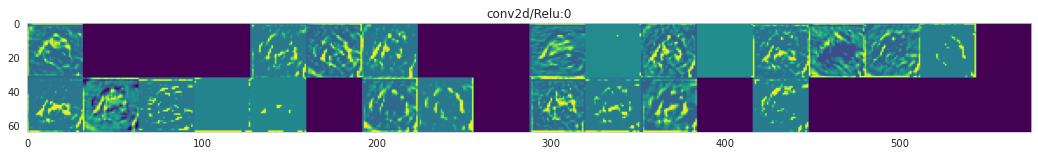

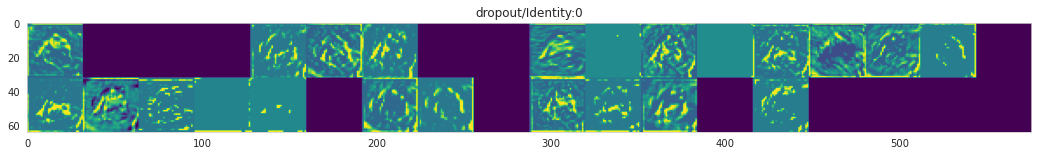

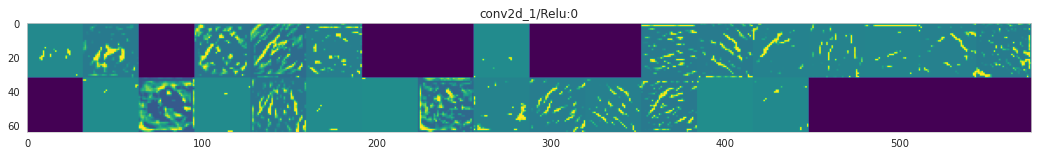

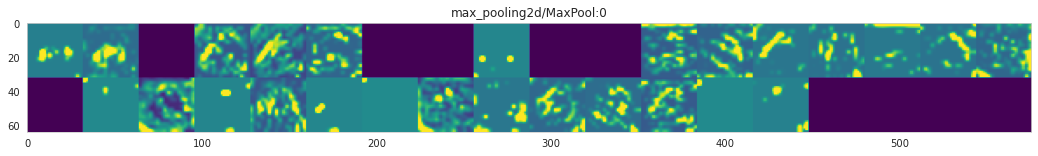

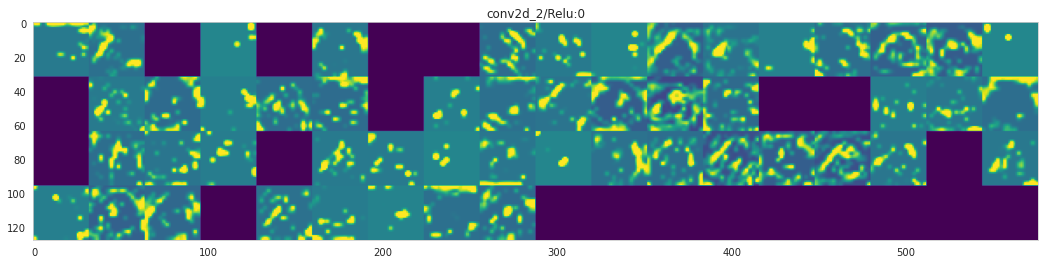

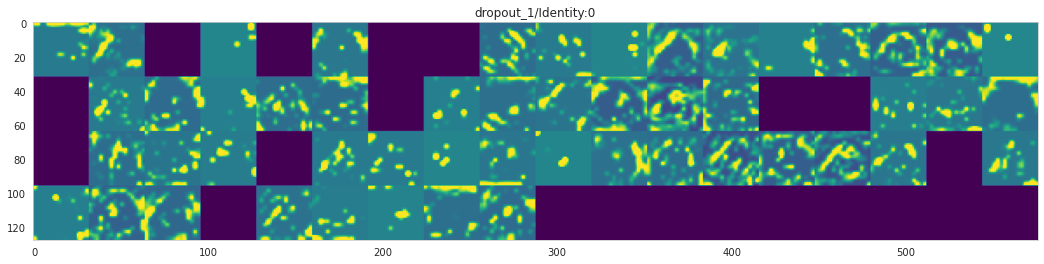

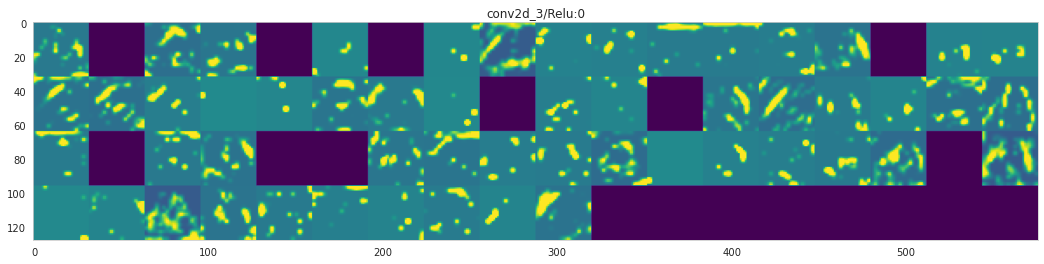

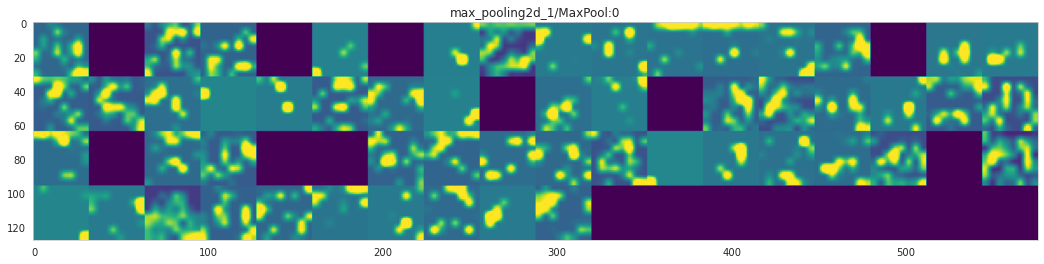

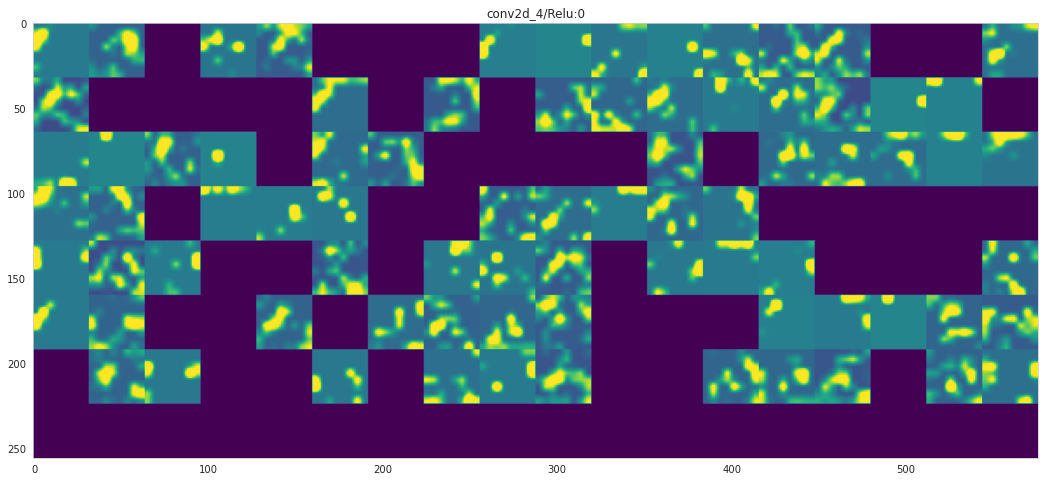

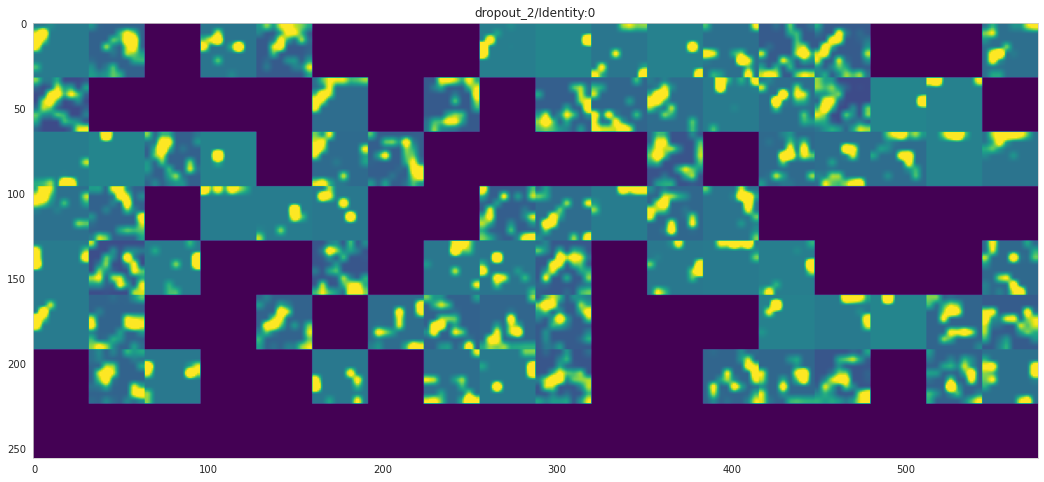

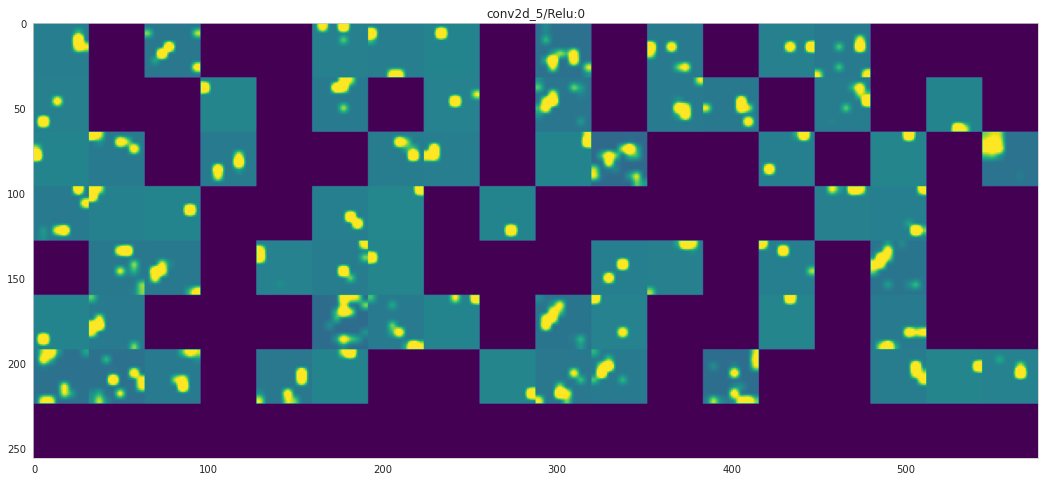

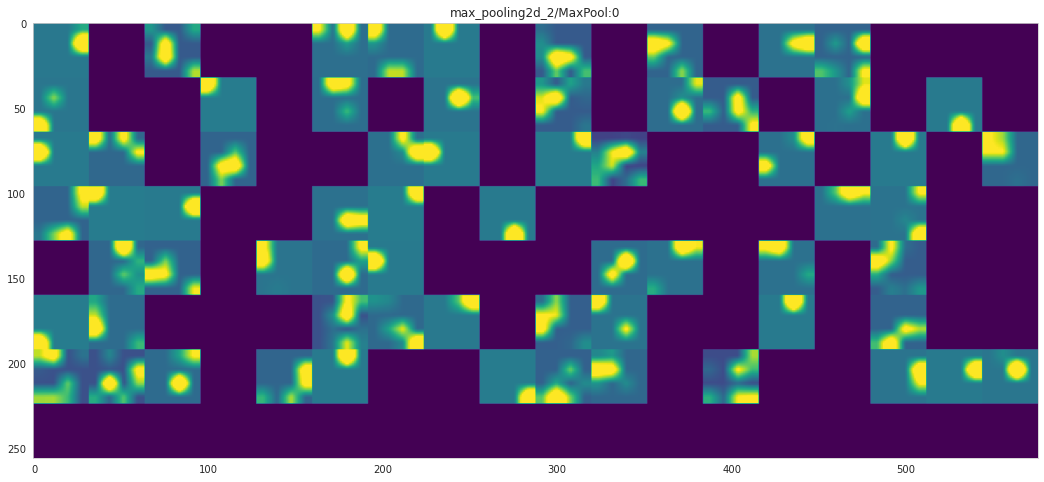

In [14]:
x_train_pos = 0  # imágen que se analizará
nlayers = 12  # número de capas convulcionales, se debe actualizar según la red configurada

# capas convulcionales
layer_outputs = [layer.output for layer in cnn_model.layers[:nlayers]]

X_train_exp_0 = tf.expand_dims(X_train[x_train_pos:x_train_pos+1], axis=-1)
activation_model = tf.keras.models.Model(inputs=cnn_model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train_exp_0)  # predicción

grid_columns = 18
grid_width = width * grid_columns

for layer, activation in zip(layer_outputs, activations):
    filters_no = activation.shape[3]

    grid_height = math.ceil(filters_no / grid_columns) * height
    # Se crea un grid negro totalmente
    display_grid = np.zeros((grid_height, grid_width))

    for filter_no in range(filters_no):
        # starts in 0
        coord_x = filter_no % grid_columns
        coord_y = math.floor(filter_no / grid_columns)

        activation_res = cv2.resize(activation[0, :, :, filter_no], dsize=(width, height))

        ### Post-processes the feature to make it visually palatable ###
        activation_res -= activation_res.mean()
        activation_res /= activation_res.std()
        activation_res *= 64
        activation_res += 128
        activation_res = np.clip(activation_res, 0, 255).astype('uint8')
        ################################################################

        display_grid[coord_y * height:coord_y * height + height, coord_x * width:coord_x * width + width] = activation_res

    plt.figure(figsize=(18, grid_height / height))
    plt.grid(False)
    plt.title(layer.name)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Analyzing the training and evaluation data.

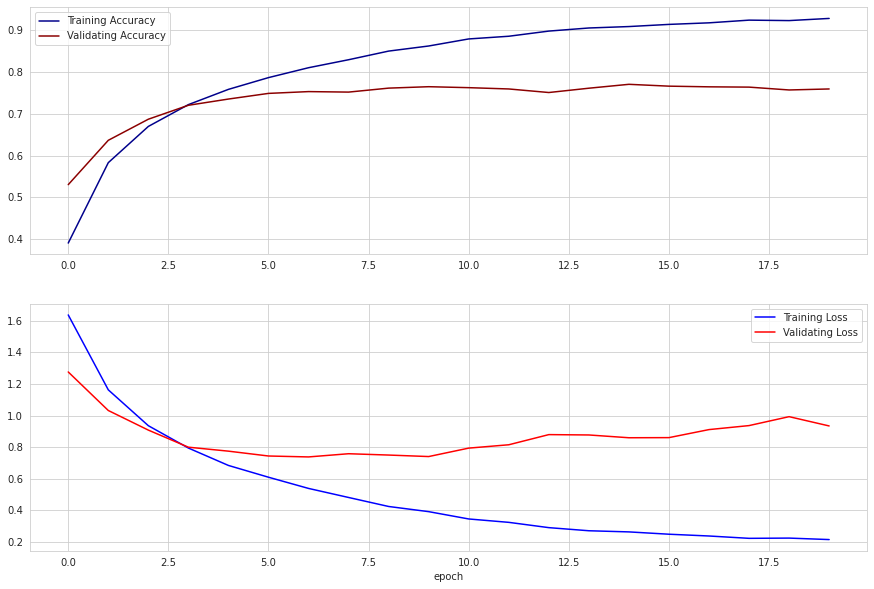

In [15]:
def plot_metrics(historial_train):
    plt.figure(figsize=(15, 10))

    acc = historial_train.history['accuracy']
    val_acc = historial_train.history['val_accuracy']
    loss = historial_train.history['loss']
    val_loss = historial_train.history['val_loss']

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(acc, color='darkblue', label='Training Accuracy')
    ax1.plot(val_acc, color='darkred', label='Validating Accuracy')
    ax1.legend()

    ax1 = plt.subplot(2, 1, 2)
    ax1.set_xlabel('epoch')
    ax1.plot(loss, color='blue', label='Training Loss')
    ax1.plot(val_loss, color='red', label='Validating Loss')
    ax1.legend()


plot_metrics(historial_train)

Model evaluation.

In [16]:
loss_train, accuracy_train = cnn_model.evaluate(X_train, y_train)
loss_test, accuracy_test = cnn_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.9340 - accuracy: 0.7591
